In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mne
!pip install mneflow


     |████████████████████████████████| 7.5 MB 4.2 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 462 kB 27.6 MB/s 


In [3]:
%matplotlib inline
import numpy as np

from scipy.io import loadmat 
import mne, glob 

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.manifold import MDS

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne import io, pick_types, read_events, Epochs, EvokedArray, create_info
from mne.preprocessing import Xdawn
from mne import combine_evoked
from mne.channels import read_layout


from mne import channels, evoked, create_info

from scipy.signal import freqz, welch
from scipy.stats import spearmanr

from matplotlib import pyplot as plt
from matplotlib import patches as ptch
from matplotlib import collections
 




In [4]:
# Load raw data

#fname_raw = os.path.join(multimodal.data_path(), 'AR_001_rFB_AR.vhdr')
raw = mne.io.read_raw_brainvision('/content/drive/Othercomputers/My MacBook Pro/LaCie/AR_mvpa/MNE/feedback/AR_001_rFB_AR.vhdr')
events,event_dict = mne.events_from_annotations(raw, verbose=False)

# 'AR_002_rFB_AR.vhdr'

raw2 = mne.io.read_raw_brainvision('/content/drive/Othercomputers/My MacBook Pro/LaCie/AR_mvpa/MNE/feedback/AR_002_rFB_AR.vhdr')
events2,event_dict2 = mne.events_from_annotations(raw2, verbose=False)


# 'AR_003_rFB_AR.vhdr'

raw3 = mne.io.read_raw_brainvision('/content/drive/Othercomputers/My MacBook Pro/LaCie/AR_mvpa/MNE/feedback/AR_003_rFB_AR.vhdr')
events3,event_dict3 = mne.events_from_annotations(raw3, verbose=False)


#'AR_004_rFB_AR.vhdr'

raw4 = mne.io.read_raw_brainvision('/content/drive/Othercomputers/My MacBook Pro/LaCie/AR_mvpa/MNE/feedback/AR_004_rFB_AR.vhdr')
events4,event_dict4 = mne.events_from_annotations(raw4, verbose=False)

event_id = {'Left Reward': 6, 'Right Reward': 7,'Left Noreward': 8, 'Right Noreward': 9 }  # just use two

## SET MONTAGE
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False)
raw2.set_montage(montage, verbose=False)
raw3.set_montage(montage, verbose=False)
raw4.set_montage(montage, verbose=False)

Extracting parameters from /content/drive/Othercomputers/My MacBook Pro/LaCie/AR_mvpa/MNE/feedback/AR_001_rFB_AR.vhdr...
Setting channel info structure...
Extracting parameters from /content/drive/Othercomputers/My MacBook Pro/LaCie/AR_mvpa/MNE/feedback/AR_002_rFB_AR.vhdr...
Setting channel info structure...
Extracting parameters from /content/drive/Othercomputers/My MacBook Pro/LaCie/AR_mvpa/MNE/feedback/AR_003_rFB_AR.vhdr...
Setting channel info structure...
Extracting parameters from /content/drive/Othercomputers/My MacBook Pro/LaCie/AR_mvpa/MNE/feedback/AR_004_rFB_AR.vhdr...
Setting channel info structure...


<RawBrainVision | AR_004_rFB_AR.txt, 13 x 995000 (995.0 s), ~26 kB, data not loaded>

In [5]:


# Construct epochs

events,event_dict = mne.events_from_annotations(raw, verbose=False)

events2,event_dict2 = mne.events_from_annotations(raw2, verbose=False)


events3,event_dict3 = mne.events_from_annotations(raw3, verbose=False)


events4,event_dict4 = mne.events_from_annotations(raw4, verbose=False)




In [ ]:
print(events2)

[[     0      0  99999]
 [  2499      0      4]
 [  2500      0      7]
 ...
 [652500      0  10006]
 [654082      0      1]
 [654093      0      4]]


## DIRECTION BINARY CONDITIONS

In [8]:
###BINARY CLASSIFICATION 

#event_id = {'Left Reward': 6, 'Right Reward': 7,'Left Noreward': 8, 'Right Noreward': 9 }  # just use two

## SUB1

#left right 

eventsLR=mne.event.merge_events(events, [6,8],1, replace_events=True)
eventsLR=mne.event.merge_events(eventsLR, [7,9],0, replace_events=True)


event_idLR = {'Left': 1,'Right': 0}  # just use two


## SUB2

#left right 

eventsLR2=mne.event.merge_events(events2, [6,8],1, replace_events=True)
eventsLR2=mne.event.merge_events(eventsLR2, [7,9],0, replace_events=True)




#left right 

eventsLR3=mne.event.merge_events(events3, [6,8],1, replace_events=True)
eventsLR3=mne.event.merge_events(eventsLR3, [7,9],0, replace_events=True)




#left right 

eventsLR4=mne.event.merge_events(events4, [6,8],1, replace_events=True)
eventsLR4=mne.event.merge_events(eventsLR4, [7,9],0, replace_events=True)






## CREATE EPOCHS FROM RAW EEG DATA SUB 1-4

#event_id = {'Left Reward': 6, 'Right Reward': 7,'Left Noreward': 8, 'Right Noreward': 9 }  # just use two
# WINDOW tmin=0, tmax=0.5, 100ms AFTER FEEDBACK 
# Setup for reading the raw data

# Setup for reading the raw data

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

reject_criteria = dict(eeg=150e-6)      # 150 µV

# Read epochs
epochsLR = mne.Epochs(raw, events=eventsLR, event_id=event_idLR, #tmin=0, tmax=0.2,                       
                    picks = picks,
                    reject=reject_criteria, 
                    proj=True, 
                    baseline=None, 
                    preload=True,
                    verbose='error')

# Read epochs
epochsLR2 = mne.Epochs(raw2, events=eventsLR2, event_id=event_idLR, #tmin=0, tmax=0.2,                     
                    picks = picks,
                    reject=reject_criteria, 
                    proj=True, 
                    baseline=None, 
                    preload=True,
                 verbose='error')
#
# Read epochs
epochsLR3 = mne.Epochs(raw3, events=eventsLR3, event_id=event_idLR, #tmin=0, tmax=0.2,                      
                    picks = picks,
                    reject=reject_criteria, 
                    proj=True, 
                    baseline=None, 
                    preload=True,
                    verbose='error')

# Read epochs
epochsLR4 = mne.Epochs(raw4, events=eventsLR4, event_id=event_idLR, #tmin=0, tmax=0.2,                     
                    picks = picks,
                    reject=reject_criteria, 
                    proj=True, 
                    baseline=None, 
                    preload=True,
                    verbose='error')


In [7]:
# create classification matrix for SUB 1-4

X = epochsLR.get_data()  # EEG signals: n_epochs, n_channels, n_times
y = epochsLR.events[:,2]  # target: left vs right 

labels = epochsLR.events[:, -1]
eeg_data = epochsLR.get_data().reshape(len(labels), -1)


X2 = epochsLR2.get_data()  # EEG signals: n_epochs, n_channels, n_times
y2 = epochsLR2.events[:,2]  # target: left vs right 

labels2 = epochsLR2.events[:, -1]
eeg_data2 = epochsLR2.get_data().reshape(len(labels2), -1)


X3= epochsLR3.get_data()  # EEG signals: n_epochs, n_channels, n_times
y3 = epochsLR3.events[:,2]  # target: left vs right 

labels3 = epochsLR3.events[:, -1]
eeg_data3 = epochsLR3.get_data().reshape(len(labels3), -1)


X4 = epochsLR4.get_data()  # EEG signals: n_epochs, n_channels, n_times
y4 = epochsLR4.events[:,2]  # target: left vs right 

labels4 = epochsLR4.events[:, -1]
eeg_data4 = epochsLR4.get_data().reshape(len(labels4), -1)



In [ ]:
print(eeg_data.shape)
print(X.shape)


(200, 9113)
(200, 13, 701)


## CLASSIFICATION

## MNEFLOW - LFCNN


In [9]:
import mneflow 
#Specify import options
#/content/drive/Othercomputers/My MacBook Pro/LaCie/FNDIII_FINAL
import_opt = dict(savepath='/content/drive/Othercomputers/My MacBook Pro/LaCie/AR_mvpa/MNE/',  # path where TFR files will be saved
                  out_name='eeg_sample_epochs',  # name of TFRecords files
                  fs=1000,
                  input_type='trials',
                  target_type='int',
                  picks={'eeg':True},
                  scale=False,  # apply baseline_scaling
                  crop_baseline=True,  # remove baseline interval after scaling
                  scale_interval=(-200, 0),  # indices in time axis corresponding to baseline interval
                  n_folds=5,  # validation set size set to 20% of all data
                  overwrite=True,
                  segment=False,
                  test_set='holdout')


#write TFRecord files and metadata file to disk
#meta = mneflow.produce_tfrecords([epochs], **import_opt)  



#array_keys={'X':'my_data_samples','y':'my_labels'}

meta = mneflow.produce_tfrecords((X,y),**import_opt)

meta2 = mneflow.produce_tfrecords((X2,y2),**import_opt)

meta3 = mneflow.produce_tfrecords((X3,y3),**import_opt)

meta4 = mneflow.produce_tfrecords((X4,y4),**import_opt)


importing from tuple
input shapes: X- (200, 13, 701) targets- (200, 1)
Preprocessing:
Splitting sets
Preprocessed: (200, 1, 701, 13) (200, 2) folds: 6 x 33
Prepocessed sample shape: (1, 701, 13)
Target shape actual/metadata:  (2,) (2,)
Saving TFRecord# 0
importing from tuple
input shapes: X- (295, 13, 201) targets- (295, 1)
Preprocessing:
Splitting sets
Preprocessed: (295, 1, 201, 13) (295, 2) folds: 6 x 49
Prepocessed sample shape: (1, 201, 13)
Target shape actual/metadata:  (2,) (2,)
Saving TFRecord# 0
importing from tuple
input shapes: X- (194, 13, 701) targets- (194, 1)
Preprocessing:
Splitting sets
Preprocessed: (194, 1, 701, 13) (194, 2) folds: 6 x 32
Prepocessed sample shape: (1, 701, 13)
Target shape actual/metadata:  (2,) (2,)
Saving TFRecord# 0
importing from tuple
input shapes: X- (199, 13, 701) targets- (199, 1)
Preprocessing:
Splitting sets
Preprocessed: (199, 1, 701, 13) (199, 2) folds: 6 x 33
Prepocessed sample shape: (1, 701, 13)
Target shape actual/metadata:  (2,) (2,)

In [10]:
dataset = mneflow.Dataset(meta, train_batch=50)
dataset2 = mneflow.Dataset(meta2, train_batch=50)
dataset3 = mneflow.Dataset(meta3, train_batch=50)
dataset4 = mneflow.Dataset(meta4, train_batch=50)


In [ ]:
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

# specify model parameters
lf_params = dict(n_latent=39, #number of latent factors from feature extractor
                  filter_length=16, #convolutional filter length in time samples used channel #
                  nonlin = tf.nn.relu,
                  padding = 'SAME',
                  pooling = 2,#pooling factor
                  stride = 2, #stride parameter for pooling layer
                  pool_type='max',
                  model_path = import_opt['savepath'],
                  dropout = .5,
                  l1_scope = ["weights"],
                  l1=3e-3)

model = mneflow.models.LFCNN(dataset, lf_params)
#model.build()
model.build(optimizer='adam', learn_rate=3e-4)


model2 = mneflow.models.LFCNN(dataset2, lf_params)
#model2.build()
model2.build(optimizer='adam', learn_rate=3e-4)

model3 = mneflow.models.LFCNN(dataset3, lf_params)
#model3.build()
model3.build(optimizer='adam', learn_rate=3e-4)

model4 = mneflow.models.LFCNN(dataset4, lf_params)
#model4.build()
model4.build(optimizer='adam', learn_rate=3e-4)


Setting reg for dmx, to l1
Built: dmx input: (None, 1, 701, 13)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 701, 39)
Setting reg for fc, to l1
Built: fc input: (None, 1, 176, 39)
Input shape: (1, 701, 13)
y_pred: (None, 2)
Initialization complete!
Setting reg for dmx, to l1
Built: dmx input: (None, 1, 201, 13)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 201, 39)
Setting reg for fc, to l1
Built: fc input: (None, 1, 51, 39)
Input shape: (1, 201, 13)
y_pred: (None, 2)
Initialization complete!
Setting reg for dmx, to l1
Built: dmx input: (None, 1, 701, 13)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 701, 39)
Setting reg for fc, to l1
Built: fc input: (None, 1, 176, 39)
Input shape: (1, 701, 13)
y_pred: (None, 2)
Initialization complete!
Setting reg for dmx, to l1
Built: dmx input: (None, 1, 701, 13)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 701, 39)
Setting reg for fc, to l1
Built: fc input: (None, 1, 176, 39)
Input shape: (1, 7

Epoch 1/25
20/20 - 2s - loss: 1.8866 - cat_ACC: 0.4935 - val_loss: 1.8441 - val_cat_ACC: 0.4000 - 2s/epoch - 89ms/step
Epoch 2/25
20/20 - 0s - loss: 1.8050 - cat_ACC: 0.4924 - val_loss: 1.7567 - val_cat_ACC: 0.6000 - 406ms/epoch - 20ms/step
Epoch 3/25
20/20 - 0s - loss: 1.7288 - cat_ACC: 0.4966 - val_loss: 1.6837 - val_cat_ACC: 0.6000 - 416ms/epoch - 21ms/step
Epoch 4/25
20/20 - 0s - loss: 1.6562 - cat_ACC: 0.5052 - val_loss: 1.6320 - val_cat_ACC: 0.4000 - 420ms/epoch - 21ms/step
Epoch 5/25
20/20 - 0s - loss: 1.5862 - cat_ACC: 0.5227 - val_loss: 1.5554 - val_cat_ACC: 0.4000 - 469ms/epoch - 23ms/step
Epoch 6/25
20/20 - 0s - loss: 1.5267 - cat_ACC: 0.4828 - val_loss: 1.4927 - val_cat_ACC: 0.4000 - 438ms/epoch - 22ms/step
Epoch 7/25
20/20 - 0s - loss: 1.4650 - cat_ACC: 0.4948 - val_loss: 1.4410 - val_cat_ACC: 0.4000 - 435ms/epoch - 22ms/step
Epoch 8/25
20/20 - 0s - loss: 1.4098 - cat_ACC: 0.5365 - val_loss: 1.4063 - val_cat_ACC: 0.4000 - 496ms/epoch - 25ms/step
Epoch 9/25
20/20 - 1s - los

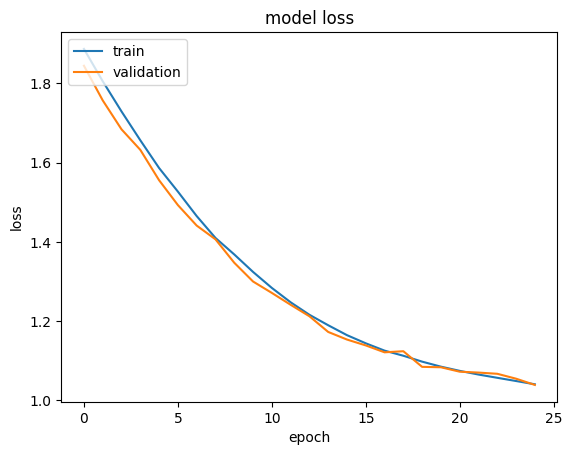

Epoch 1/25
20/20 - 1s - loss: 1.8790 - cat_ACC: 0.5118 - val_loss: 1.8333 - val_cat_ACC: 0.5185 - 1s/epoch - 54ms/step
Epoch 2/25
20/20 - 0s - loss: 1.8151 - cat_ACC: 0.4764 - val_loss: 1.7705 - val_cat_ACC: 0.4815 - 296ms/epoch - 15ms/step
Epoch 3/25
20/20 - 0s - loss: 1.7417 - cat_ACC: 0.4819 - val_loss: 1.7047 - val_cat_ACC: 0.4815 - 309ms/epoch - 15ms/step
Epoch 4/25
20/20 - 0s - loss: 1.6729 - cat_ACC: 0.5250 - val_loss: 1.6392 - val_cat_ACC: 0.4815 - 305ms/epoch - 15ms/step
Epoch 5/25
20/20 - 0s - loss: 1.6208 - cat_ACC: 0.4931 - val_loss: 1.5797 - val_cat_ACC: 0.4815 - 339ms/epoch - 17ms/step
Epoch 6/25
20/20 - 0s - loss: 1.5554 - cat_ACC: 0.4931 - val_loss: 1.5311 - val_cat_ACC: 0.4815 - 308ms/epoch - 15ms/step
Epoch 7/25
20/20 - 0s - loss: 1.5007 - cat_ACC: 0.4947 - val_loss: 1.4801 - val_cat_ACC: 0.4815 - 316ms/epoch - 16ms/step
Epoch 8/25
20/20 - 0s - loss: 1.4489 - cat_ACC: 0.4917 - val_loss: 1.4200 - val_cat_ACC: 0.4815 - 328ms/epoch - 16ms/step
Epoch 9/25
20/20 - 0s - los

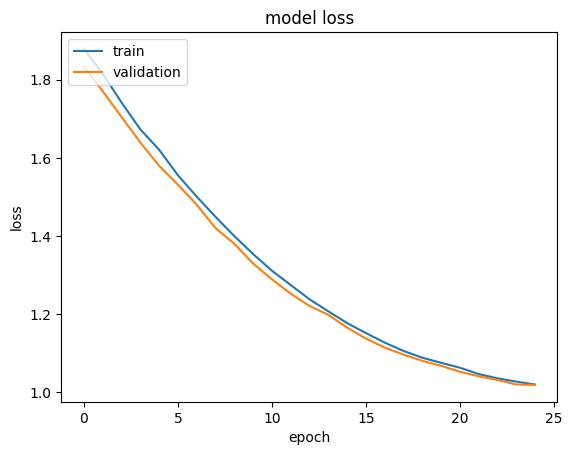

Epoch 1/25
20/20 - 1s - loss: 1.8865 - cat_ACC: 0.5472 - val_loss: 1.8579 - val_cat_ACC: 0.3793 - 1s/epoch - 52ms/step
Epoch 2/25
20/20 - 0s - loss: 1.8241 - cat_ACC: 0.5708 - val_loss: 1.8157 - val_cat_ACC: 0.3793 - 294ms/epoch - 15ms/step
Epoch 3/25
20/20 - 0s - loss: 1.7644 - cat_ACC: 0.5379 - val_loss: 1.8049 - val_cat_ACC: 0.3793 - 300ms/epoch - 15ms/step
Epoch 4/25
20/20 - 0s - loss: 1.7006 - cat_ACC: 0.5445 - val_loss: 1.7202 - val_cat_ACC: 0.3793 - 339ms/epoch - 17ms/step
Epoch 5/25
20/20 - 0s - loss: 1.6479 - cat_ACC: 0.5536 - val_loss: 1.6371 - val_cat_ACC: 0.3793 - 308ms/epoch - 15ms/step
Epoch 6/25
20/20 - 0s - loss: 1.5993 - cat_ACC: 0.5579 - val_loss: 1.5810 - val_cat_ACC: 0.3793 - 287ms/epoch - 14ms/step
Epoch 7/25
20/20 - 0s - loss: 1.5432 - cat_ACC: 0.5445 - val_loss: 1.6114 - val_cat_ACC: 0.3793 - 288ms/epoch - 14ms/step
Epoch 8/25
20/20 - 0s - loss: 1.4902 - cat_ACC: 0.5579 - val_loss: 1.4925 - val_cat_ACC: 0.3793 - 290ms/epoch - 14ms/step
Epoch 9/25
20/20 - 0s - los

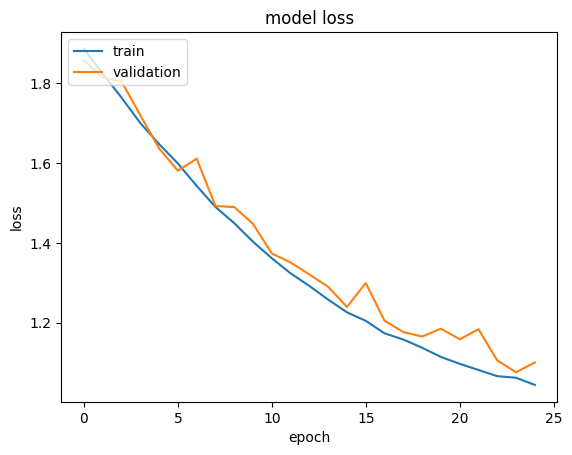

In [ ]:
#train the model for 100 epochs
model.train(n_epochs=25, eval_step=20, early_stopping=5)
model.plot_hist()



model3.train(n_epochs=25, eval_step=20, early_stopping=5)
model3.plot_hist()


model4.train(n_epochs=25, eval_step=20, early_stopping=5)
model4.plot_hist()

In [ ]:

model2.train(n_epochs=25, eval_step=20, early_stopping=5)
model2.plot_hist()

Epoch 1/25


InvalidArgumentError: ignored

In [ ]:
test_loss, test_acc = model.evaluate(meta['test_paths'])
test_loss3, test_acc3 = model3.evaluate(meta3['test_paths'])
test_loss4, test_acc4 = model4.evaluate(meta4['test_paths'])


1/1 [==============================] - 0s 36ms/step - loss: 1.0536 - cat_ACC: 0.5152


In [ ]:
model.compute_patterns()
model3.compute_patterns()
model4.compute_patterns()

Computing patterns: No path specified, using validation dataset (Default)
Computing patterns: No path specified, using validation dataset (Default)
Computing patterns: No path specified, using validation dataset (Default)


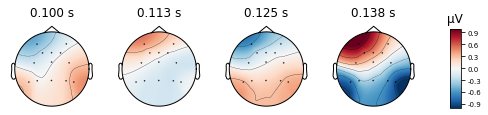

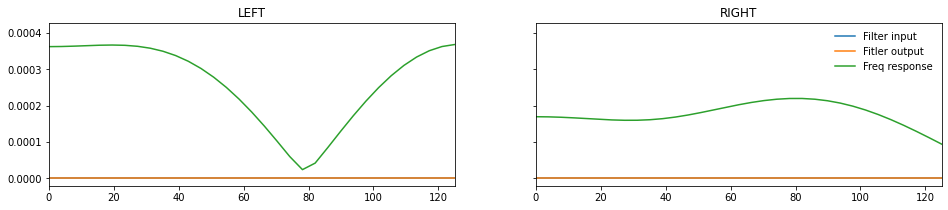

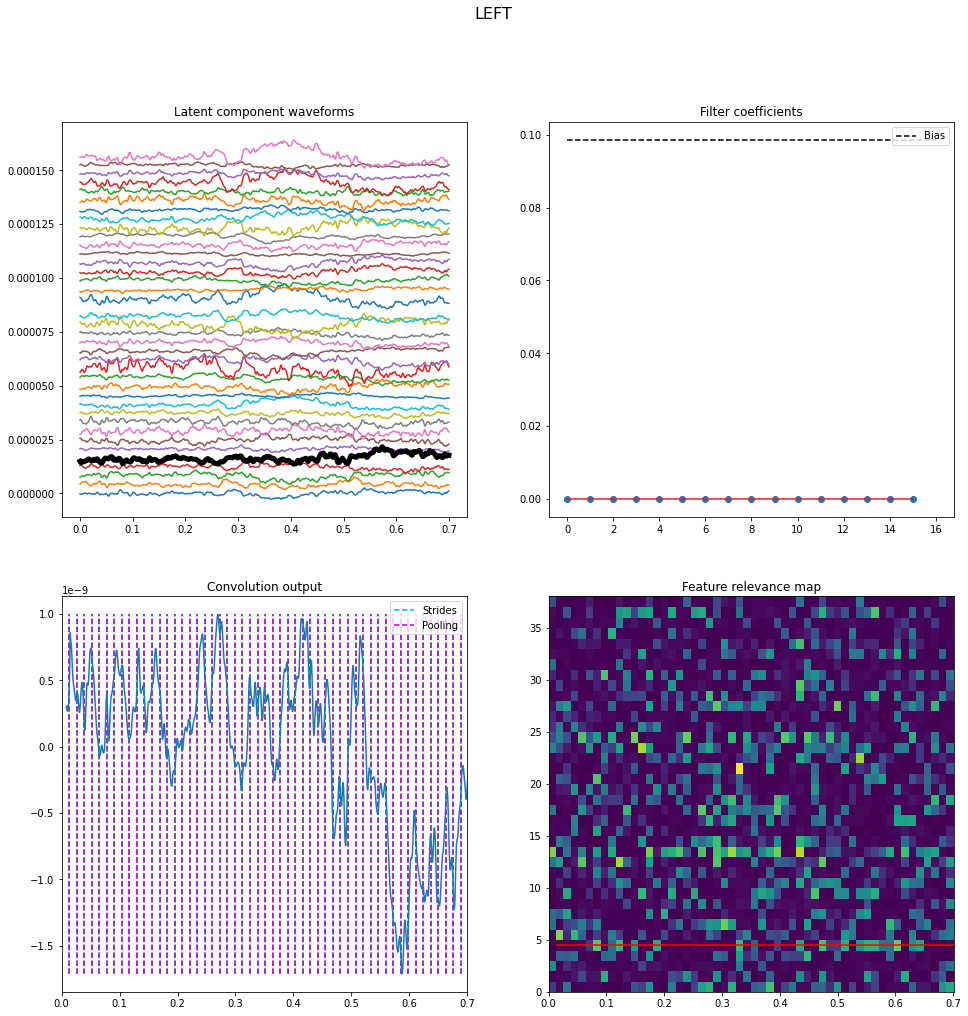

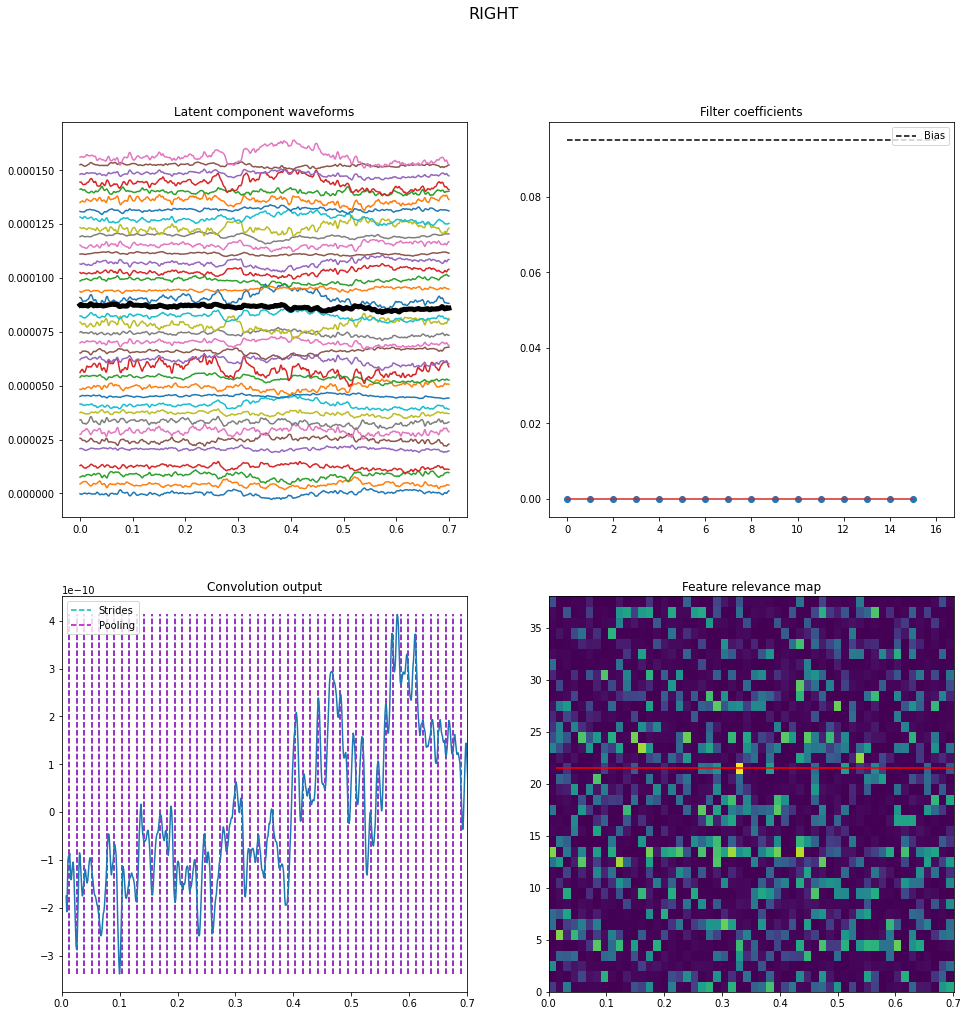

In [ ]:
fake_evoked = evoked.EvokedArray(model.patterns, info=epochsLR.info, tmin=0.1)

fake_evoked.plot_topomap()

condition_names = ['LEFT', 'RIGHT']


f2 = model.plot_spectra(sorting='weight_corr', norm_spectra='welch', class_names=condition_names)
f3 = model.plot_waveforms(sorting='compwise_loss', class_names=condition_names)




In [ ]:
fake_evoked2 = evoked.EvokedArray(model2.patterns, info=epochsLR2.info, tmin=0.1)

fake_evoked2.plot_topomap()

condition_names = ['LEFT', 'RIGHT']


f2 = model.plot_spectra(sorting='weight_corr', norm_spectra='welch', class_names=condition_names)
f3 = model.plot_waveforms(sorting='compwise_loss', class_names=condition_names)




AttributeError: ignored

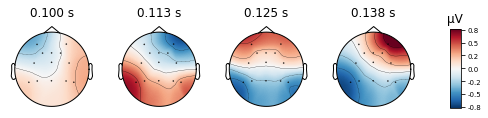

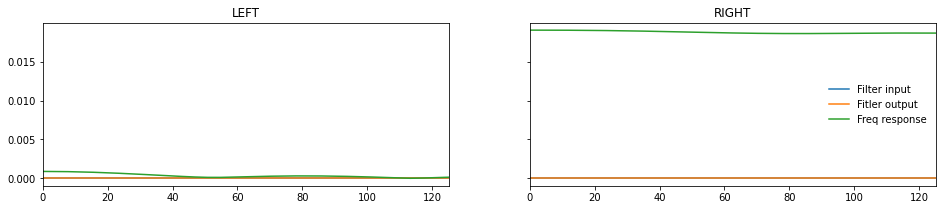

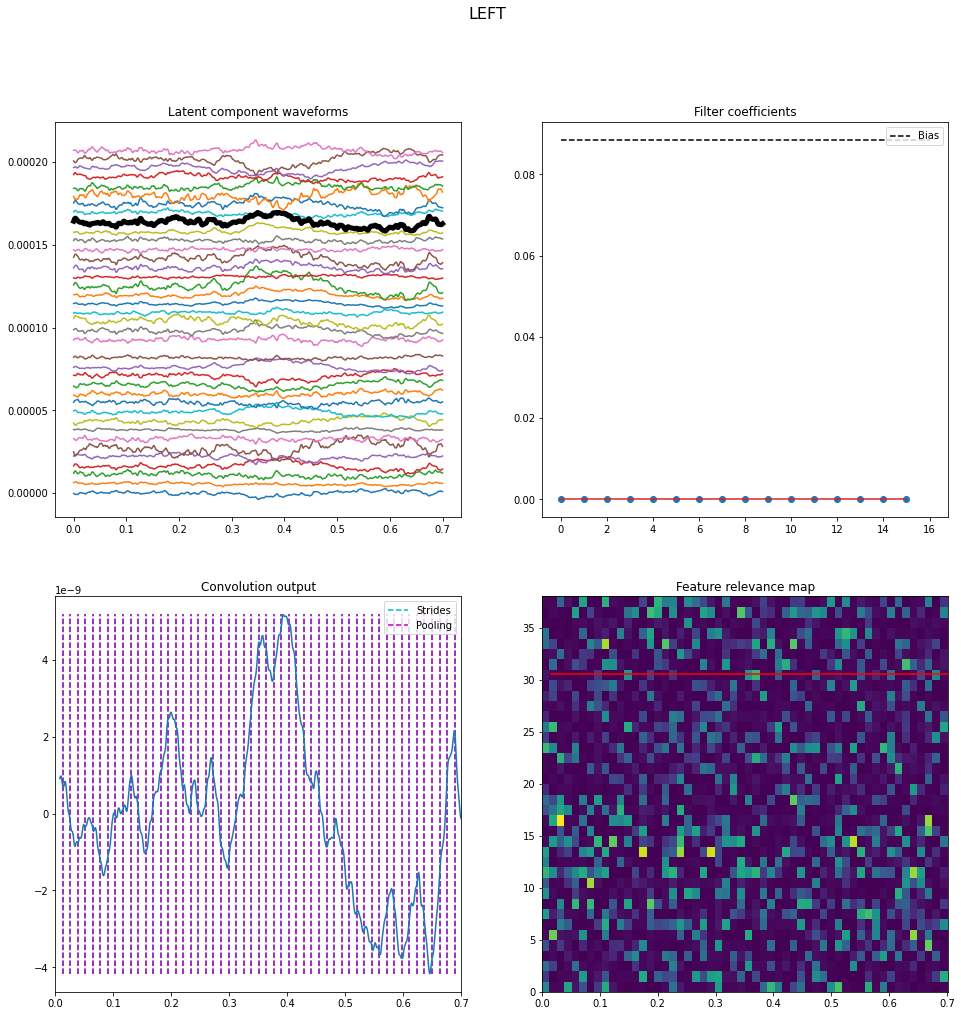

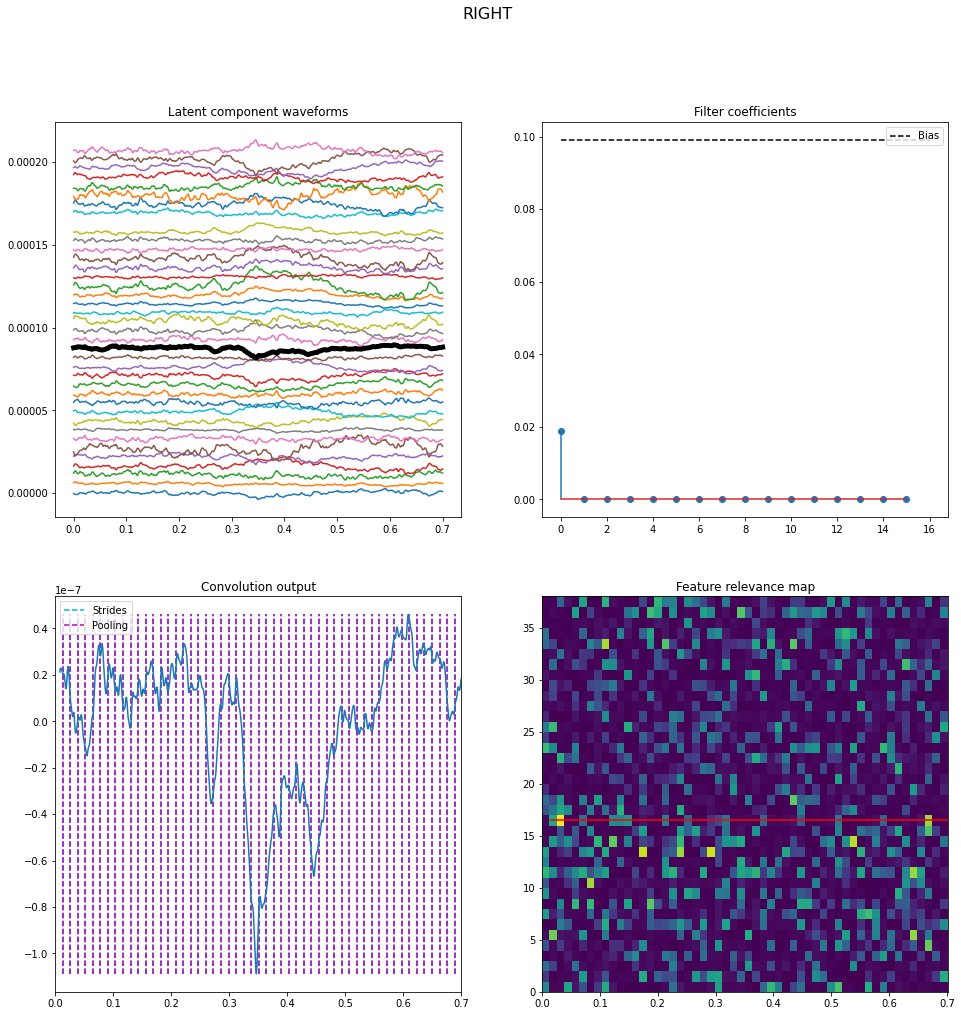

In [ ]:
fake_evoked3 = evoked.EvokedArray(model3.patterns, info=epochsLR3.info, tmin=0.1)

fake_evoked3.plot_topomap()

condition_names = ['LEFT', 'RIGHT']


f2b = model3.plot_spectra(sorting='weight_corr', norm_spectra='welch', class_names=condition_names)
f3b = model3.plot_waveforms(sorting='compwise_loss', class_names=condition_names)



In [ ]:
fake_evoked4 = evoked.EvokedArray(model4.patterns, info=epochsLR4.info, tmin=0.1)

fake_evoked4.plot_topomap()

condition_names = ['LEFT', 'RIGHT']


f2c = model4.plot_spectra(sorting='weight_corr', norm_spectra='welch', class_names=condition_names)
f3c = model4.plot_waveforms(sorting='compwise_loss', class_names=condition_names)

AttributeError: ignored

## NEURAL NETWORKS 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()

#sub 1 

scaler.fit(eeg_data)
x_new = scaler.transform(eeg_data)

data_mean = eeg_data.mean()
data_std = eeg_data.std()
x = (eeg_data - data_mean)/data_std


#sub 2 

scaler.fit(eeg_data2)
x_new2 = scaler.transform(eeg_data2)

data_mean2 = eeg_data2.mean()
data_std2 = eeg_data2.std()
x2 = (eeg_data2 - data_mean2)/data_std2



#sub 3 

scaler.fit(eeg_data3)
x_new3 = scaler.transform(eeg_data3)

data_mean3 = eeg_data3.mean()
data_std3 = eeg_data3.std()
x3 = (eeg_data3 - data_mean3)/data_std3


#sub 4 

scaler.fit(eeg_data4)
x_new4 = scaler.transform(eeg_data4)

data_mean4 = eeg_data4.mean()
data_std4 = eeg_data4.std()
x4 = (eeg_data4 - data_mean4)/data_std4


In [ ]:
#

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y, stratify=y)


X_train2, X_test2, y_train2, y_test2 = train_test_split(x2,y2, stratify=y2)



X_train3, X_test3, y_train3, y_test3 = train_test_split(x3,y3, stratify=y3)



X_train4, X_test4, y_train4, y_test4 = train_test_split(x4,y4, stratify=y4)




In [ ]:

print(X_train.shape)
print(y_test)

(150, 9113)
[1 1 1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 1 0 0 1 0
 1 1 0 0 1 1 1 1 0 1 1 1 1]


In [ ]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(40,13),
                        max_iter = 150,activation = 'relu',
                        solver = 'sgd', alpha= 0.05, learning_rate= 'adaptive')


mlp_clf2 = MLPClassifier(hidden_layer_sizes=(40,13),
                        max_iter = 150,activation = 'relu',
                        solver = 'sgd', alpha= 0.05, learning_rate= 'adaptive')


mlp_clf3 = MLPClassifier(hidden_layer_sizes=(40,13),
                        max_iter = 150,activation = 'relu',
                        solver = 'sgd', alpha= 0.05, learning_rate= 'adaptive')


mlp_clf4 = MLPClassifier(hidden_layer_sizes=(40,13),
                        max_iter = 150,activation = 'relu',
                        solver = 'sgd', alpha= 0.05, learning_rate= 'adaptive')


#mlp_clf.fit(trainX_scaled, y_train)
mlp_clf.fit(X_train, y_train)

mlp_clf2.fit(X_train2, y_train2)

mlp_clf3.fit(X_train3, y_train3)

mlp_clf4.fit(X_train4, y_train4)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(alpha=0.05, hidden_layer_sizes=(40, 13), learning_rate='adaptive',
              max_iter=150, solver='sgd')

In [ ]:
#y_pred = mlp_clf.predict(testX_scaled)
y_pred = mlp_clf.predict(X_test)

print('Subject 1 Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))



y_pred2 = mlp_clf2.predict(X_test2)

print('Subject 2 Accuracy: {:.2f}'.format(accuracy_score(y_test2, y_pred2)))


y_pred3 = mlp_clf3.predict(X_test3)

print('Subject 3 Accuracy: {:.2f}'.format(accuracy_score(y_test3, y_pred3)))

y_pred4 = mlp_clf4.predict(X_test4)

print('Subject 4 Accuracy: {:.2f}'.format(accuracy_score(y_test4, y_pred4)))



Subject 1 Accuracy: 0.56
Subject 2 Accuracy: 0.80
Subject 3 Accuracy: 0.53
Subject 4 Accuracy: 0.54


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


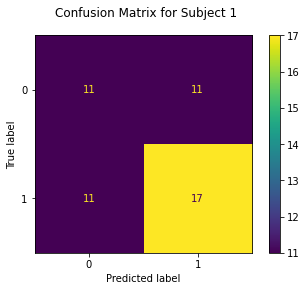

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


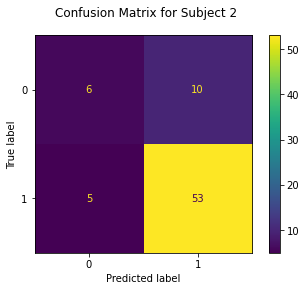

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


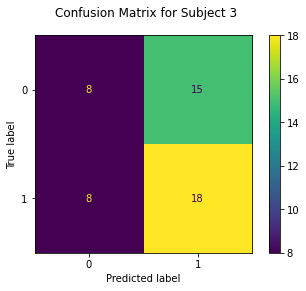

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


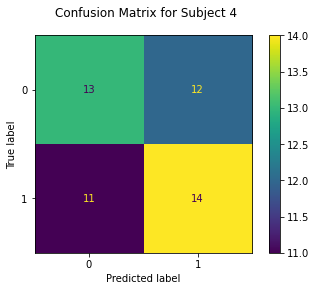

In [ ]:
fig = plot_confusion_matrix(mlp_clf, X_test, y_test, display_labels=mlp_clf.classes_)
fig.figure_.suptitle("Confusion Matrix for Subject 1")
plt.show()




fig2 = plot_confusion_matrix(mlp_clf2, X_test2, y_test2, display_labels=mlp_clf2.classes_)
fig2.figure_.suptitle("Confusion Matrix for Subject 2")
plt.show()




fig3 = plot_confusion_matrix(mlp_clf3, X_test3, y_test3, display_labels=mlp_clf3.classes_)
fig3.figure_.suptitle("Confusion Matrix for Subject 3")
plt.show()




fig4 = plot_confusion_matrix(mlp_clf4, X_test4, y_test4, display_labels=mlp_clf4.classes_)
fig4.figure_.suptitle("Confusion Matrix for Subject 4")
plt.show()




In [ ]:
print(classification_report(y_test, y_pred))


print(classification_report(y_test2, y_pred2))



print(classification_report(y_test3, y_pred3))



print(classification_report(y_test4, y_pred4))



              precision    recall  f1-score   support

           0       0.50      0.50      0.50        22
           1       0.61      0.61      0.61        28

    accuracy                           0.56        50
   macro avg       0.55      0.55      0.55        50
weighted avg       0.56      0.56      0.56        50

              precision    recall  f1-score   support

           0       0.55      0.38      0.44        16
           1       0.84      0.91      0.88        58

    accuracy                           0.80        74
   macro avg       0.69      0.64      0.66        74
weighted avg       0.78      0.80      0.78        74

              precision    recall  f1-score   support

           0       0.50      0.35      0.41        23
           1       0.55      0.69      0.61        26

    accuracy                           0.53        49
   macro avg       0.52      0.52      0.51        49
weighted avg       0.52      0.53      0.52        49

              preci

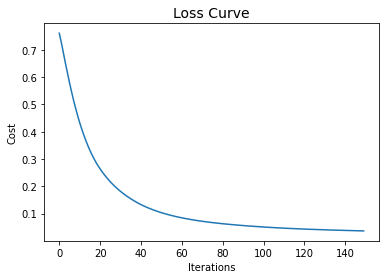

In [ ]:

plt.plot(mlp_clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [ ]:
from sklearn import metrics
score_p = []
score_p2 = []
score_p3 = []
score_p4 = []


score_p.append([metrics.accuracy_score(y_test, y_pred), metrics.precision_score(y_test, y_pred),metrics.recall_score(y_test, y_pred),metrics.f1_score(y_test, y_pred)])


score_p2.append([metrics.accuracy_score(y_test2, y_pred2), metrics.precision_score(y_test2, y_pred2),metrics.recall_score(y_test2, y_pred2),metrics.f1_score(y_test2, y_pred2)])


score_p3.append([metrics.accuracy_score(y_test3, y_pred3), metrics.precision_score(y_test3, y_pred3),metrics.recall_score(y_test3, y_pred3),metrics.f1_score(y_test3, y_pred3)])

score_p4.append([metrics.accuracy_score(y_test4, y_pred4), metrics.precision_score(y_test4, y_pred4),metrics.recall_score(y_test4, y_pred4),metrics.f1_score(y_test4, y_pred4)])


#Training on Neural Networks



#Creating CNN Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# CREATE MODEL 

model = Sequential()
model.add(Dense(40, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate = 0.2))
model.add(Dense(13, activation='relu'))
model.add(Dropout(rate = 0.2))
model.add(Dense(1, activation = 'sigmoid'))


model2 = Sequential()
model2.add(Dense(40, activation = 'relu', input_dim = X_train2.shape[1]))
model2.add(Dropout(rate = 0.2))
model2.add(Dense(13, activation='relu'))
model2.add(Dropout(rate = 0.2))
model2.add(Dense(1, activation = 'sigmoid'))



model3 = Sequential()
model3.add(Dense(40, activation = 'relu', input_dim = X_train3.shape[1]))
model3.add(Dropout(rate = 0.2))
model3.add(Dense(13, activation='relu'))
model3.add(Dropout(rate = 0.2))
model3.add(Dense(1, activation = 'sigmoid'))



model4 = Sequential()
model4.add(Dense(40, activation = 'relu', input_dim = X_train4.shape[1]))
model4.add(Dropout(rate = 0.2))
model4.add(Dense(13, activation='relu'))
model4.add(Dropout(rate = 0.2))
model4.add(Dense(1, activation = 'sigmoid'))



In [ ]:
model.compile(loss = 'mse',optimizer = 'adam', metrics = ['accuracy'])

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()


model2.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])

###model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model2.summary()


model3.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])

#model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model3.summary()


model4.compile(loss = 'mse',optimizer = 'adam',metrics = ['accuracy'])

##model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 40)                364560    
                                                                 
 dropout_24 (Dropout)        (None, 40)                0         
                                                                 
 dense_33 (Dense)            (None, 13)                533       
                                                                 
 dropout_25 (Dropout)        (None, 13)                0         
                                                                 
 dense_34 (Dense)            (None, 1)                 14        
                                                                 
Total params: 365,107
Trainable params: 365,107
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
________________________

##Training


In [ ]:
from keras.callbacks import ModelCheckpoint


model.fit(X_train, y_train, batch_size = 13, epochs= 50, verbose = 1)

model2.fit(X_train2, y_train2, batch_size = 13, epochs= 50, verbose = 1)


model3.fit(X_train3, y_train3, batch_size = 13, epochs= 50, verbose = 1)


model4.fit(X_train4, y_train4, batch_size = 13, epochs= 50, verbose = 1)



#checkpointer = ModelCheckpoint(filepath = 'MLP.weights.best.hdf5', verbose = 1, save_best_only = True)
#hist = model.fit(X_train, y_train, epochs = 100, batch_size=13, validation_split = 0.1, verbose = 1, shuffle = True)
#callbacks = [checkpointer],

Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.4012 - accuracy: 0.5000
Epoch 2/50
12/12 [==============================] - 0s 3ms/step - loss: 0.2292 - accuracy: 0.7267
Epoch 3/50
12/12 [==============================] - 0s 3ms/step - loss: 0.1953 - accuracy: 0.7333
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1809 - accuracy: 0.7467
Epoch 5/50
12/12 [==============================] - 0s 3ms/step - loss: 0.1508 - accuracy: 0.7867
Epoch 6/50
12/12 [==============================] - 0s 3ms/step - loss: 0.1351 - accuracy: 0.8133
Epoch 7/50
12/12 [==============================] - 0s 3ms/step - loss: 0.1339 - accuracy: 0.8400
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1107 - accuracy: 0.8533
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1076 - accuracy: 0.8800
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0999 - accuracy: 0.8867
Epoch 11/50
12/12 [

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: ", score[1])


score2 = model2.evaluate(X_test2, y_test2, verbose=1)
print("Accuracy: ", score2[1])

score3 = model3.evaluate(X_test3, y_test3, verbose=1)
print("Accuracy: ", score3[1])


score4 = model4.evaluate(X_test4, y_test4, verbose=1)
print("Accuracy: ", score4[1])




2/2 [==============================] - 0s 10ms/step - loss: 0.4330 - accuracy: 0.5200
Accuracy:  0.5199999809265137
3/3 [==============================] - 0s 5ms/step - loss: 0.1719 - accuracy: 0.8108
Accuracy:  0.8108108043670654
2/2 [==============================] - 0s 8ms/step - loss: 0.3400 - accuracy: 0.6122
Accuracy:  0.6122449040412903
2/2 [==============================] - 0s 8ms/step - loss: 0.4065 - accuracy: 0.5600
Accuracy:  0.5600000023841858


In [ ]:
predict = [1 if a>0.5 else 0 for a in model.predict(X_test)] 
predict2 = [1 if a>0.5 else 0 for a in model2.predict(X_test2)] 

predict3 = [1 if a>0.5 else 0 for a in model3.predict(X_test3)] 
predict4 = [1 if a>0.5 else 0 for a in model4.predict(X_test4)] 


In [ ]:
print(y_test4)
print(predict4)

[0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0
 1 1 0 1 0 1 0 1 1 1 1 1 0]
[1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0]


##Performance


In [ ]:
from sklearn import metrics
print("Subject 1 \nCNN Accuracy = {}\nPrecision = {}\nRecall = {}\nF1 Score = {}".format(metrics.accuracy_score(y_test, predict), metrics.precision_score(y_test, predict),metrics.recall_score(y_test, predict),metrics.f1_score(y_test, predict)))
print("Subject 2 \nCNN Accuracy = {}\nPrecision = {}\nRecall = {}\nF1 Score = {}".format(metrics.accuracy_score(y_test2, predict2), metrics.precision_score(y_test2, predict2),metrics.recall_score(y_test2, predict2),metrics.f1_score(y_test2, predict2)))

print("Subject 3 \nCNN Accuracy = {}\nPrecision = {}\nRecall = {}\nF1 Score = {}".format(metrics.accuracy_score(y_test3, predict3), metrics.precision_score(y_test3, predict3),metrics.recall_score(y_test3, predict3),metrics.f1_score(y_test3, predict3)))

print("Subject 4 \nCNN Accuracy = {}\nPrecision = {}\nRecall = {}\nF1 Score = {}".format(metrics.accuracy_score(y_test4, predict4), metrics.precision_score(y_test4, predict4),metrics.recall_score(y_test4, predict4),metrics.f1_score(y_test4, predict4)))






Subject 1 
CNN Accuracy = 0.52
Precision = 0.5769230769230769
Recall = 0.5357142857142857
F1 Score = 0.5555555555555555
Subject 2 
CNN Accuracy = 0.8108108108108109
Precision = 0.8548387096774194
Recall = 0.9137931034482759
F1 Score = 0.8833333333333333
Subject 3 
CNN Accuracy = 0.6122448979591837
Precision = 0.6060606060606061
Recall = 0.7692307692307693
F1 Score = 0.6779661016949152
Subject 4 
CNN Accuracy = 0.56
Precision = 0.5714285714285714
Recall = 0.48
F1 Score = 0.5217391304347826


In [ ]:

score_p.append([metrics.accuracy_score(y_test, predict), metrics.precision_score(y_test, predict),metrics.recall_score(y_test, predict),metrics.f1_score(y_test, predict)])
score_p2.append([metrics.accuracy_score(y_test2, predict2), metrics.precision_score(y_test2, predict2),metrics.recall_score(y_test2, predict2),metrics.f1_score(y_test2, predict2)])


score_p3.append([metrics.accuracy_score(y_test3, predict3), metrics.precision_score(y_test3, predict3),metrics.recall_score(y_test3, predict3),metrics.f1_score(y_test3, predict3)])

score_p4.append([metrics.accuracy_score(y_test4, predict4), metrics.precision_score(y_test4, predict4),metrics.recall_score(y_test4, predict4),metrics.f1_score(y_test4, predict4)])


##Training on LSTM


##Creating 3D array dataset


In [ ]:
print(X.shape)
print(y.shape)

(200, 13, 701)
(200,)


In [ ]:
X_test =X[0:99,:,:]
y_test = y[0:99]

X_train=X[100:200,:,:]
y_train=y[100:200]


X_test2 =X2[0:99,:,:]
y_test2 = y2[0:99]

X_train2=X2[100:200,:,:]
y_train2=y2[100:200]

X_test3 =X3[0:99,:,:]
y_test3 = y3[0:99]

X_train3=X3[100:200,:,:]
y_train3=y3[100:200]



X_test4 =X4[0:99,:,:]
y_test4 = y4[0:99]

X_train4=X4[100:200,:,:]
y_train4=y4[100:200]



In [ ]:
print(X_train2.shape[1])
print(X_train2.shape[2])

13
201


In [ ]:

from tensorflow.keras import Sequential
from keras.layers import Bidirectional, LSTM

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
#tf.keras.backend.clear_session()

model5 = Sequential()
model5.add(LSTM(40, input_shape=(X_train.shape[1], X_train.shape[2])))
model5.add(Dropout(rate = 0.2))
model5.add(Dense(1, activation = 'sigmoid'))


model6 = Sequential()
model6.add(LSTM(40, input_shape=(X_train2.shape[1], X_train2.shape[2])))
model6.add(Dropout(rate = 0.2))
model6.add(Dense(1, activation = 'sigmoid'))

model7 = Sequential()
model7.add(LSTM(40, input_shape=(X_train3.shape[1], X_train3.shape[2])))
model7.add(Dropout(rate = 0.2))
model7.add(Dense(1, activation = 'sigmoid'))



model8 = Sequential()
model8.add(LSTM(40, input_shape=(X_train4.shape[1], X_train4.shape[2])))
model8.add(Dropout(rate = 0.2))
model8.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model5.compile(
                loss = 'mse',
                optimizer = 'adam',
                metrics = ['accuracy'])


model5.summary()

model6.compile(
                loss = 'mse',
                optimizer = 'adam',
                metrics = ['accuracy'])


model6.summary()




model7.compile(
                loss = 'mse',
                optimizer = 'adam',
                metrics = ['accuracy'])


model7.summary()

model8.compile(
                loss = 'mse',
                optimizer = 'adam',
                metrics = ['accuracy'])


model8.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 40)                118720    
                                                                 
 dropout_32 (Dropout)        (None, 40)                0         
                                                                 
 dense_44 (Dense)            (None, 1)                 41        
                                                                 
Total params: 118,761
Trainable params: 118,761
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 40)                38720     
                                                                 
 dropout_33 (Dropout)   

In [ ]:
from keras.callbacks import ModelCheckpoint

#checkpointer = ModelCheckpoint(filepath = 'LSTM.weights.best.hdf5', verbose = 1, save_best_only = True)
hist = model5.fit(X_train, y_train, batch_size = 13, epochs= 50, verbose = 1)

hist2 = model6.fit(X_train2, y_train2, batch_size = 13, epochs= 50, verbose = 1)

hist3 = model7.fit(X_train3, y_train3, batch_size = 13, epochs= 50, verbose = 1)



hist4 = model8.fit(X_train4, y_train4, batch_size = 13, epochs= 50, verbose = 1)



#callbacks = [checkpointer],

Epoch 1/50
8/8 [==============================] - 2s 6ms/step - loss: 0.2494 - accuracy: 0.5800
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.2479 - accuracy: 0.6100
Epoch 3/50
8/8 [==============================] - 0s 5ms/step - loss: 0.2445 - accuracy: 0.6100
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.2414 - accuracy: 0.6100
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 0.2400 - accuracy: 0.6100
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.2390 - accuracy: 0.6100
Epoch 7/50
8/8 [==============================] - 0s 5ms/step - loss: 0.2384 - accuracy: 0.6100
Epoch 8/50
8/8 [==============================] - 0s 6ms/step - loss: 0.2385 - accuracy: 0.6100
Epoch 9/50
8/8 [==============================] - 0s 5ms/step - loss: 0.2375 - accuracy: 0.6100
Epoch 10/50
8/8 [==============================] - 0s 5ms/step - loss: 0.2398 - accuracy: 0.6100
Epoch 11/50
8/8 [======================

In [ ]:
score5 = model5.evaluate(X_test, y_test, verbose=1)
print("Accuracy: ", score5[1])


score6 = model6.evaluate(X_test2, y_test2, verbose=1)
print("Accuracy: ", score6[1])

score7 = model7.evaluate(X_test3, y_test3, verbose=1)
print("Accuracy: ", score7[1])



score8 = model8.evaluate(X_test4, y_test4, verbose=1)
print("Accuracy: ", score8[1])



4/4 [==============================] - 0s 5ms/step - loss: 0.2627 - accuracy: 0.4949
Accuracy:  0.49494948983192444
4/4 [==============================] - 0s 6ms/step - loss: 0.1958 - accuracy: 0.7374
Accuracy:  0.7373737096786499
4/4 [==============================] - 0s 5ms/step - loss: 0.2549 - accuracy: 0.4949
Accuracy:  0.49494948983192444
4/4 [==============================] - 0s 5ms/step - loss: 0.2500 - accuracy: 0.4949
Accuracy:  0.49494948983192444


In [ ]:
predict5 =  [1 if a>0.5 else 0 for a in model5.predict(X_test)]
predict6 =  [1 if a>0.5 else 0 for a in model6.predict(X_test2)]

predict7 =  [1 if a>0.5 else 0 for a in model7.predict(X_test3)]
predict8 =  [1 if a>0.5 else 0 for a in model8.predict(X_test4)]


## PERFORMACE

In [ ]:
print("Subject 1 \nLSTM Accuracy = {}\nPrecision = {}\nRecall = {}\nF1 Score = {}".format(metrics.accuracy_score(y_test, predict5), metrics.precision_score(y_test, predict5),metrics.recall_score(y_test, predict5),metrics.f1_score(y_test, predict5)))

print("Subject 2 \nLSTM Accuracy = {}\nPrecision = {}\nRecall = {}\nF1 Score = {}".format(metrics.accuracy_score(y_test2, predict6), metrics.precision_score(y_test2, predict6),metrics.recall_score(y_test2, predict6),metrics.f1_score(y_test2, predict6)))


print("Subject 3 \nLSTM Accuracy = {}\nPrecision = {}\nRecall = {}\nF1 Score = {}".format(metrics.accuracy_score(y_test3, predict7), metrics.precision_score(y_test3, predict7),metrics.recall_score(y_test3, predict7),metrics.f1_score(y_test3, predict7)))

print("Subject 4 \nLSTM Accuracy = {}\nPrecision = {}\nRecall = {}\nF1 Score = {}".format(metrics.accuracy_score(y_test4, predict8), metrics.precision_score(y_test4, predict8),metrics.recall_score(y_test4, predict8),metrics.f1_score(y_test4, predict8)))


score_p.append([metrics.accuracy_score(y_test, predict5), metrics.precision_score(y_test, predict5),metrics.recall_score(y_test, predict5),metrics.f1_score(y_test, predict5)])

score_p2.append([metrics.accuracy_score(y_test2, predict6), metrics.precision_score(y_test2, predict6),metrics.recall_score(y_test2, predict6),metrics.f1_score(y_test2, predict6)])


score_p3.append([metrics.accuracy_score(y_test3, predict7), metrics.precision_score(y_test3, predict7),metrics.recall_score(y_test3, predict7),metrics.f1_score(y_test3, predict7)])

score_p4.append([metrics.accuracy_score(y_test4, predict8), metrics.precision_score(y_test4, predict8),metrics.recall_score(y_test4, predict8),metrics.f1_score(y_test4, predict8)])


Subject 1 
LSTM Accuracy = 0.494949494949495
Precision = 0.494949494949495
Recall = 1.0
F1 Score = 0.6621621621621622
Subject 2 
LSTM Accuracy = 0.7373737373737373
Precision = 0.7373737373737373
Recall = 1.0
F1 Score = 0.8488372093023255
Subject 3 
LSTM Accuracy = 0.494949494949495
Precision = 0.494949494949495
Recall = 1.0
F1 Score = 0.6621621621621622
Subject 4 
LSTM Accuracy = 0.494949494949495
Precision = 0.494949494949495
Recall = 1.0
F1 Score = 0.6621621621621622


In [ ]:
Subject 1 
LSTM Accuracy = 0.494949494949495
Precision = 0.494949494949495
Recall = 1.0
F1 Score = 0.6621621621621622
Subject 2 
LSTM Accuracy = 0.7373737373737373
Precision = 0.7373737373737373
Recall = 1.0
F1 Score = 0.8488372093023255
Subject 3 
LSTM Accuracy = 0.494949494949495
Precision = 0.494949494949495
Recall = 1.0
F1 Score = 0.6621621621621622
Subject 4 
LSTM Accuracy = 0.494949494949495
Precision = 0.494949494949495
Recall = 1.0
F1 Score = 0.6621621621621622

## plot

##Conclusion


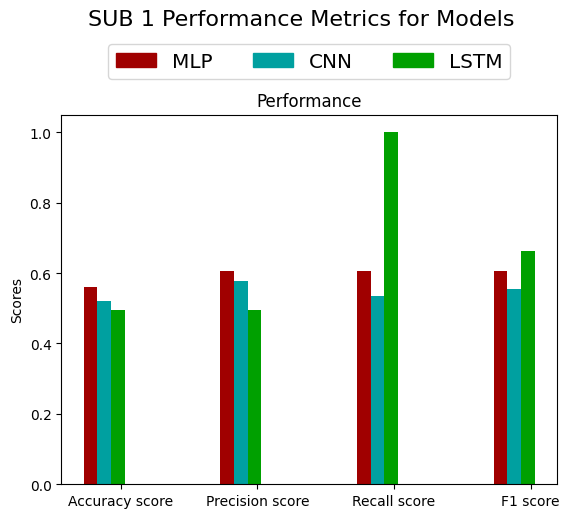

In [ ]:
##For plotting the results code is copied from Udacity Finding Donors for Charity ML Project
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

objects = ['Accuracy score', 'Precision score', 'Recall score', 'F1 score']
w =  0.10
y_pos = np.arange(len(objects))

color = ['#A00000','#00A0A0','#00A000', '#FFFF00']
s = 0
for i in range(len(score_p)):
    plt.bar(y_pos+s, score_p[i], color = color[i], width = w )
    s += w
    
plt.xticks(y_pos + 0.22, objects)
plt.ylabel('Scores')
plt.title('Performance')
plt.suptitle("SUB 1 Performance Metrics for Models", fontsize = 16, y = 1.10)

p = ['MLP', 'CNN', 'LSTM']

patches = []

for k in range(len(p)):
    patches.append(mpatches.Patch(color = color[k], label = p[k]))

plt.legend(handles = patches, bbox_to_anchor = (0.5, 1.19),loc = 'upper center', borderaxespad = 0., ncol = 4, fontsize = 'x-large')

plt.show();

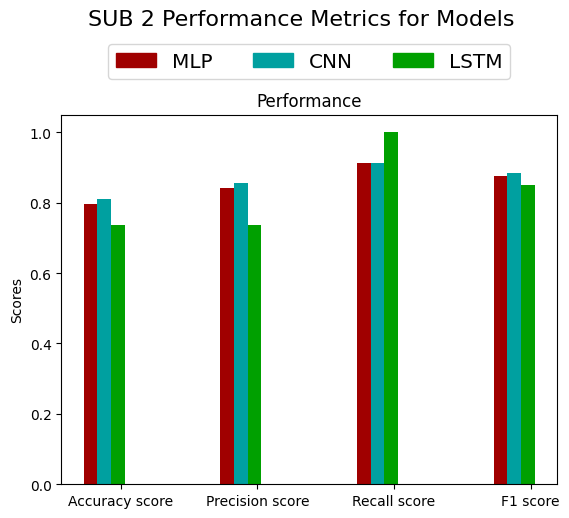

In [ ]:
objects = ['Accuracy score', 'Precision score', 'Recall score', 'F1 score']
w =  0.10
y_pos = np.arange(len(objects))

color = ['#A00000','#00A0A0','#00A000', '#FFFF00']
s = 0
for i in range(len(score_p2)):
    plt.bar(y_pos+s, score_p2[i], color = color[i], width = w )
    s += w
    
plt.xticks(y_pos + 0.22, objects)
plt.ylabel('Scores')
plt.title('Performance')
plt.suptitle("SUB 2 Performance Metrics for Models", fontsize = 16, y = 1.10)

p = ['MLP', 'CNN', 'LSTM']

patches = []

for k in range(len(p)):
    patches.append(mpatches.Patch(color = color[k], label = p[k]))

plt.legend(handles = patches, bbox_to_anchor = (0.5, 1.19),loc = 'upper center', borderaxespad = 0., ncol = 4, fontsize = 'x-large')

plt.show();

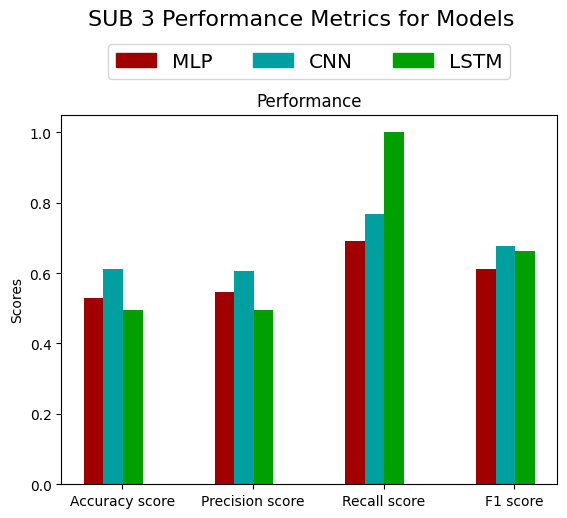

In [ ]:
objects = ['Accuracy score', 'Precision score', 'Recall score', 'F1 score']
w =  0.15
y_pos = np.arange(len(objects))

color = ['#A00000','#00A0A0','#00A000', '#FFFF00']
s = 0
for i in range(len(score_p3)):
    plt.bar(y_pos+s, score_p3[i], color = color[i], width = w )
    s += w
    
plt.xticks(y_pos + 0.22, objects)
plt.ylabel('Scores')
plt.title('Performance')
plt.suptitle("SUB 3 Performance Metrics for Models", fontsize = 16, y = 1.10)

p = ['MLP', 'CNN', 'LSTM']

patches = []

for k in range(len(p)):
    patches.append(mpatches.Patch(color = color[k], label = p[k]))

plt.legend(handles = patches, bbox_to_anchor = (0.5, 1.19),loc = 'upper center', borderaxespad = 0., ncol = 4, fontsize = 'x-large')

plt.show();

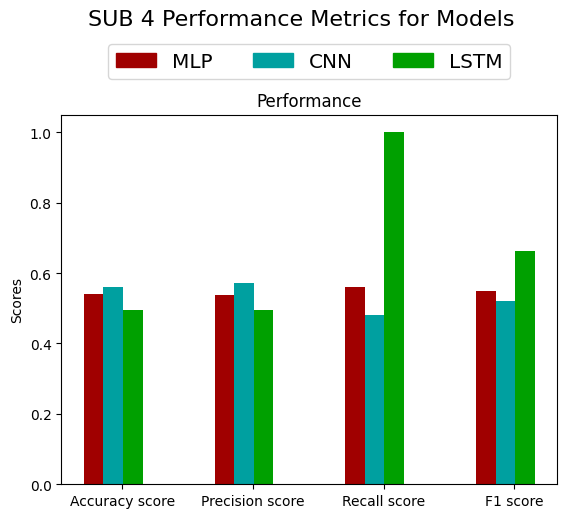

In [ ]:
objects = ['Accuracy score', 'Precision score', 'Recall score', 'F1 score']
w =  0.15
y_pos = np.arange(len(objects))

color = ['#A00000','#00A0A0','#00A000', '#FFFF00']
s = 0
for i in range(len(score_p4)):
    plt.bar(y_pos+s, score_p4[i], color = color[i], width = w )
    s += w
    
plt.xticks(y_pos + 0.22, objects)
plt.ylabel('Scores')
plt.title('Performance')
plt.suptitle("SUB 4 Performance Metrics for Models", fontsize = 16, y = 1.10)

p = ['MLP', 'CNN', 'LSTM']

patches = []

for k in range(len(p)):
    patches.append(mpatches.Patch(color = color[k], label = p[k]))

plt.legend(handles = patches, bbox_to_anchor = (0.5, 1.19),loc = 'upper center', borderaxespad = 0., ncol = 4, fontsize = 'x-large')

plt.show();